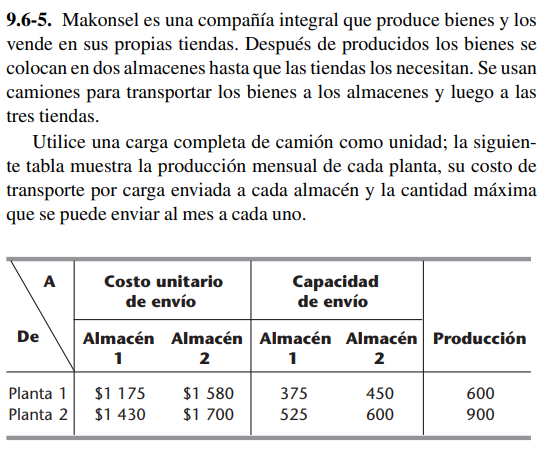


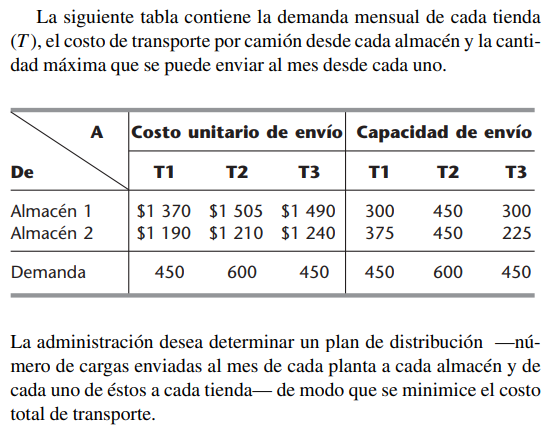


## Optimization model

#### Sets & subsets
* $N$: Set of nodes in the network, i $\in$ {0,1,…,N} 
* $A$: Set of arcs in the network, k $\in$ {0,1,…,A}
* $P$ $\subset N$: Subset of nodes that represent the beginning of the network (plants), p $\in$ {0,1,…,P}
* $E$ $\subset N$: Subset of nodes that represent intermediaries of the network, e $\in$ {0,1,…,E}
* $T$ $\subset N$: Subset of nodes that represent the end of the network (stores), t $\in$ {0,1,…,T}

#### Parameters
* $c_{i,j}$: Is the unit transportation cost from node ${i}$ to node ${j}$, $\forall (i,j) \in A$
* $u_{i,j}$: Is the maximum capacity to send from node ${i}$ to node ${j}$, $\forall (i,j) \in A$
* $p_{i}$: Is the production in the node ${i}$, $\forall i \in P \subset N$
* $d_{i}$: Is the demand in the node ${i}$, $\forall i \in T \subset N$

#### Decision variables
* $x_{i,j}$: Is the number of units to be send from node ${i}$ to node ${j}$, $\forall (i,j) \in A$

#### Objective function
$$\ Min\space \ Z = \sum_{(i,j) \in A} c_{i,j}*x_{i,j}  $$

#### Constraints
Balance
$$ \sum_{(i,j) \in A} x_{i,j} = \sum_{(j,k) \in A} x_{j,k}, \forall j \in N - P \cup T  $$
Capacity
$$ 0 \leq x_{i,j} \leq u_{i,j}, \forall (i,j) \in A $$
Production
$$ \sum_{(i,j) \in A} x_{i,j} = p_{i}, \forall i \in P \subset N $$
Demand satisfaction
$$ \sum_{(j,k) \in A} x_{j,k} = d_{k}, \forall k \in T \subset N $$
Non negative
$$ x_{i,j} \geq 0, \forall (i,j) \in A $$

## Code

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import pyomo.environ as pe
import pyomo.opt as po

In [2]:
nodes = {'P1','P2','A1','A2','T1','T2','T3'}
planta = {'P1','P2'}
almacen = {'A1','A2'}
tienda = {'T1','T2','T3'}
arcs = {('P1','A1'), ('P1','A2'), ('P2','A1'), 
        ('P2','A2'), ('A1','T1'), ('A1','T2'), 
        ('A1','T3'), ('A2','T1'), ('A2','T2'), ('A2','T3')}
capacity = {('P1','A1'): 375, ('P1','A2'): 450, ('P2','A1'): 525, 
            ('P2','A2'): 600, ('A1','T1'): 300, ('A1','T2'): 450, 
            ('A1','T3'): 300, ('A2','T1'): 375, ('A2','T2'): 450, ('A2','T3'): 225}
cost = {('P1','A1'): 1175, ('P1','A2'): 1580, ('P2','A1'): 1430, 
        ('P2','A2'): 1700, ('A1','T1'): 1370, ('A1','T2'): 1505, 
        ('A1','T3'): 1490, ('A2','T1'): 1190, ('A2','T2'): 1210, ('A2','T3'): 1240}
production = {'P1': 600, 'P2': 900}
demand = {'T1': 450, 'T2': 600, 'T3': 450}

In [3]:
graph = nx.DiGraph()
graph.add_nodes_from(list(nodes))
graph.add_edges_from(list(arcs))
pos = ({'P1': (0,0), 'P2': (6,0), 'A1': (2,2), 'A2': (4,2),
        'T1': (0,4), 'T2': (3,4), 'T3': (6,4)})

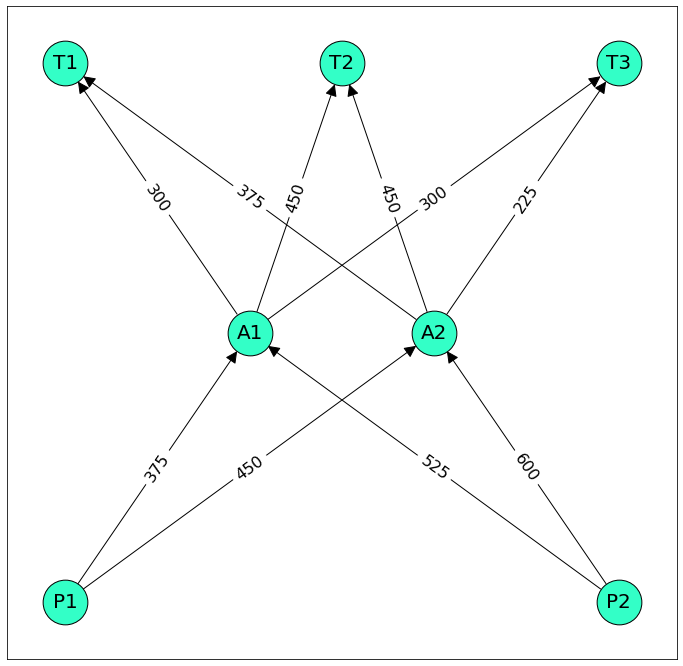

In [4]:
fig, ax = plt.subplots(figsize = (12,12))
nx.draw_networkx_nodes(graph, pos = pos, ax = ax, node_color = '#33FFC7',
                      edgecolors = 'black', node_size = 2000)
nx.draw_networkx_labels(graph, pos = pos, ax = ax, labels = dict(zip(nodes, nodes)),
                       font_size = 20)
nx.draw_networkx_edges(graph, pos=pos, ax=ax, node_size=2000, arrowsize = 25)
nx.draw_networkx_edge_labels(graph, pos=pos, ax=ax, edge_labels=capacity,
                            font_size=16, rotate = True)
plt.show()

In [5]:
exits = defaultdict(set)
entry = defaultdict(set)
for (i,j) in arcs:
    exits[i].add(j)
    entry[j].add(i)

In [6]:
#Sets and subsets
model = pe.ConcreteModel()
model.nodes = pe.Set(initialize = nodes)
model.plants = pe.Set(within = model.nodes, initialize = planta)
model.store = pe.Set(within = model.nodes, initialize = tienda)
model.intermediary = pe.Set(within = model.nodes, initialize = almacen)
model.arcs = pe.Set(within = model.nodes*model.nodes, initialize = arcs)
model.entry = pe.Param(model.nodes, initialize = entry, default=set(), within = pe.Any)
model.exit = pe.Param(model.nodes, initialize = exits, default=set(), within = pe.Any)

    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo


In [7]:
#Parameters
model.max_cap = pe.Param(model.arcs, initialize = capacity) 
model.cost = pe.Param(model.arcs, initialize = cost)
model.production = pe.Param(model.plants, initialize = production)
model.demand = pe.Param(model.store, initialize = demand)

In [8]:
#Decision variables
model.x = pe.Var(model.arcs, domain=pe.NonNegativeReals)

In [9]:
#Objetive function
def calculate_cost(model):
    cost = sum((model.x[i,j]) * model.cost[i,j] for (i,j) in model.arcs if j not in model.store)
    return cost
model.obj_function_cost = pe.Objective(sense = pe.minimize, rule = calculate_cost)

In [10]:
#Constraints
##Balance
def balance(model, i):
    flow_in  = sum([model.x[j,i] for j in model.entry[i]])
    flow_out = sum([model.x[i,j] for j in model.exit[i]])      

    if i in model.plants:
        constraint = (flow_out == model.production[i])
    elif i in model.store:
        constraint = (flow_in == model.demand[i])
    else:
        constraint = (flow_in == flow_out)
    return constraint

model.flow_balance = pe.Constraint(model.nodes, rule = balance)

In [11]:
def arcs_capacity(model, i, j):
    max_flow = model.max_cap[i,j]
    flow = model.x[i,j]
    return (0, flow, max_flow)

model.arc_capacity = pe.Constraint(model.arcs, rule = arcs_capacity)

In [12]:
model.flow_balance.pprint()

flow_balance : Size=7, Index=nodes, Active=True
    Key : Lower : Body                                                   : Upper : Active
     A1 :   0.0 : x[P2,A1] + x[P1,A1] - (x[A1,T3] + x[A1,T1] + x[A1,T2]) :   0.0 :   True
     A2 :   0.0 : x[P2,A2] + x[P1,A2] - (x[A2,T3] + x[A2,T1] + x[A2,T2]) :   0.0 :   True
     P1 : 600.0 :                                    x[P1,A2] + x[P1,A1] : 600.0 :   True
     P2 : 900.0 :                                    x[P2,A2] + x[P2,A1] : 900.0 :   True
     T1 : 450.0 :                                    x[A2,T1] + x[A1,T1] : 450.0 :   True
     T2 : 600.0 :                                    x[A2,T2] + x[A1,T2] : 600.0 :   True
     T3 : 450.0 :                                    x[A2,T3] + x[A1,T3] : 450.0 :   True


In [13]:
model.arc_capacity.pprint()

arc_capacity : Size=10, Index=arcs, Active=True
    Key          : Lower : Body     : Upper : Active
    ('A1', 'T1') :   0.0 : x[A1,T1] : 300.0 :   True
    ('A1', 'T2') :   0.0 : x[A1,T2] : 450.0 :   True
    ('A1', 'T3') :   0.0 : x[A1,T3] : 300.0 :   True
    ('A2', 'T1') :   0.0 : x[A2,T1] : 375.0 :   True
    ('A2', 'T2') :   0.0 : x[A2,T2] : 450.0 :   True
    ('A2', 'T3') :   0.0 : x[A2,T3] : 225.0 :   True
    ('P1', 'A1') :   0.0 : x[P1,A1] : 375.0 :   True
    ('P1', 'A2') :   0.0 : x[P1,A2] : 450.0 :   True
    ('P2', 'A1') :   0.0 : x[P2,A1] : 525.0 :   True
    ('P2', 'A2') :   0.0 : x[P2,A2] : 600.0 :   True


In [14]:
model.obj_function_cost.pprint()

obj_function_cost : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 1175*x[P1,A1] + 1700*x[P2,A2] + 1430*x[P2,A1] + 1580*x[P1,A2]


In [17]:
solver = pe.SolverFactory('glpk')
result = solver.solve(model, tee=True)
pe.value(model.obj_function_cost)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpta6ly4rl.glpk.raw --wglp
 C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmphnxy6awh.glpk.glp --cpxlp C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpyylaac0o.pyomo.lp
Reading problem data from 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpyylaac0o.pyomo.lp'...
28 rows, 11 columns, 41 non-zeros
147 lines were read
Writing problem data to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmphnxy6awh.glpk.glp'...
113 lines were written
GLPK Simplex Optimizer 5.0
28 rows, 11 columns, 41 non-zeros
Preprocessing...
7 rows, 10 columns, 20 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6
      0: obj =   2.235000000e+06 inf =   1.800e+03 (6)
      4: obj =   2.275500000e+06 inf =   0.000e+00 (0)
*     6: obj =   2.184375000e+06 inf =   0.000e+00 (0)
OP

2184375.0

In [18]:
model.x.pprint()

x : Size=10, Index=arcs
    Key          : Lower : Value : Upper : Fixed : Stale : Domain
    ('A1', 'T1') :     0 : 150.0 :  None : False : False : NonNegativeReals
    ('A1', 'T2') :     0 : 450.0 :  None : False : False : NonNegativeReals
    ('A1', 'T3') :     0 : 300.0 :  None : False : False : NonNegativeReals
    ('A2', 'T1') :     0 : 300.0 :  None : False : False : NonNegativeReals
    ('A2', 'T2') :     0 : 150.0 :  None : False : False : NonNegativeReals
    ('A2', 'T3') :     0 : 150.0 :  None : False : False : NonNegativeReals
    ('P1', 'A1') :     0 : 375.0 :  None : False : False : NonNegativeReals
    ('P1', 'A2') :     0 : 225.0 :  None : False : False : NonNegativeReals
    ('P2', 'A1') :     0 : 525.0 :  None : False : False : NonNegativeReals
    ('P2', 'A2') :     0 : 375.0 :  None : False : False : NonNegativeReals
